In [30]:
# %% [markdown]
# ## Breast Cancer Survival Prediction Project

# %% [markdown]
# ### 1. Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, RocCurveDisplay
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')



In [4]:
# Load dataset
df = pd.read_excel('METABRIC_Data.xlsx', sheet_name='Sheet1')


In [5]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [13]:
print(df.columns)

Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
       'overall_survival_(months)', 'overall_survival_status', 'pr_status',
       'radio_therapy', 'relapse_free_status_(months)', 'relapse_free_status',
       'sex', '3-gene_classifier_subtype', 'tumor_size', 'tumor_stage',
       'patient's_vital_status'],
      dtype='object')


In [15]:
# Handle missing values
df = df.dropna(subset=['overall_survival_(months)', 'overall_survival_status'])

# %% [markdown]
# ### 3. Target Variable Engineering
# Create 10-year mortality target
df['10_year_mortality'] = np.where(
    (df['overall_survival_(months)'] <= 120) & 
    (df['overall_survival_status'] == 'Deceased'), 1, 0)

# Handle right-censored data
df.loc[(df['overall_survival_(months)'] < 120) & 
       (df['overall_survival_status'] == 'Living'), '10_year_mortality'] = np.nan
df = df.dropna(subset=['10_year_mortality'])


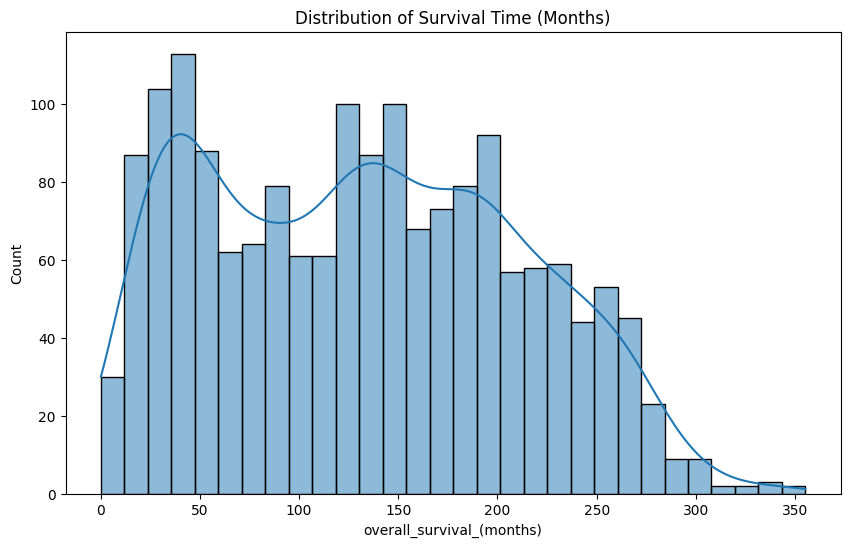

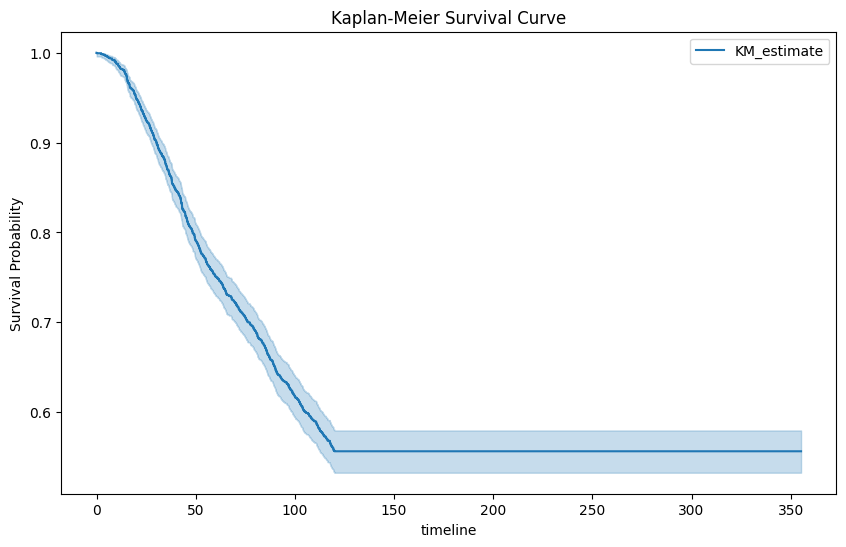

In [17]:

plt.figure(figsize=(10, 6))
sns.histplot(df['overall_survival_(months)'], bins=30, kde=True)
plt.title('Distribution of Survival Time (Months)')
plt.show()

# Kaplan-Meier analysis
kmf = KaplanMeierFitter()
kmf.fit(df['overall_survival_(months)'], event_observed=df['10_year_mortality'])

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.ylabel('Survival Probability')
plt.show()

In [18]:
# Select relevant features
features = ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type_detailed',
            'er_status', 'her2_status', 'tumor_stage', 'tumor_size', 
            'neoplasm_histologic_grade', 'lymph_nodes_examined_positive',
            'nottingham_prognostic_index', 'chemotherapy', 'hormone_therapy',
            'radio_therapy']

# Preprocessing pipeline
numeric_features = ['age_at_diagnosis', 'tumor_size', 
                    'lymph_nodes_examined_positive', 'nottingham_prognostic_index']
categorical_features = ['type_of_breast_surgery', 'er_status', 'her2_status',
                        'neoplasm_histologic_grade', 'chemotherapy', 
                        'hormone_therapy', 'radio_therapy']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])


In [21]:
for col in numeric_features:
    df[col] = df[col].fillna(df[col].mean()) # or median, as appropriate

for col in categorical_features:
    df[col] = df[col].fillna(df[col].mode()[0])  # Most frequent value

In [22]:
# Prepare data
X = df[features]
y = df['10_year_mortality']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipeline (Corrected ColumnTransformer)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing *after* splitting
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_processed, y_train)

# Model pipeline
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True)
}

# Model training and evaluation
results = {}
for name, model in models.items():
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    results[name] = {
        'roc_auc': roc_auc_score(y_test, y_proba),
        'classification_report': classification_report(y_test, y_pred)
    }

<Figure size 1000x600 with 0 Axes>

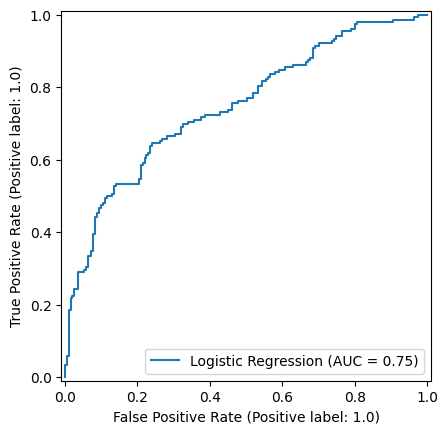

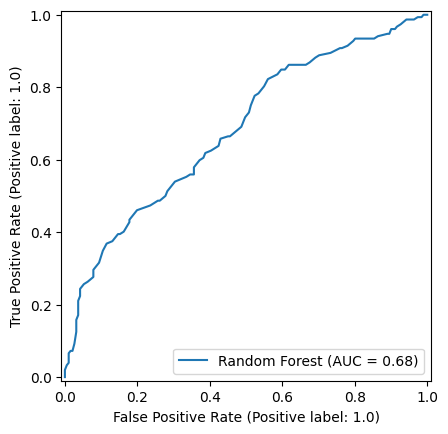

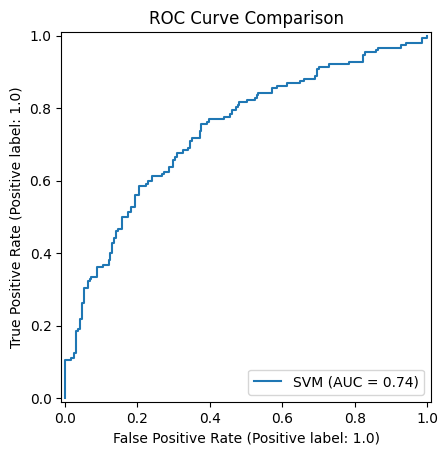

Model: Logistic Regression
ROC-AUC: 0.746
              precision    recall  f1-score   support

         0.0       0.73      0.72      0.72       191
         1.0       0.65      0.66      0.66       152

    accuracy                           0.69       343
   macro avg       0.69      0.69      0.69       343
weighted avg       0.69      0.69      0.69       343



Model: Random Forest
ROC-AUC: 0.682
              precision    recall  f1-score   support

         0.0       0.65      0.65      0.65       191
         1.0       0.56      0.56      0.56       152

    accuracy                           0.61       343
   macro avg       0.61      0.61      0.61       343
weighted avg       0.61      0.61      0.61       343



Model: SVM
ROC-AUC: 0.737
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71       191
         1.0       0.64      0.64      0.64       152

    accuracy                           0.68       343
   macro avg       0

In [23]:
plt.figure(figsize=(10, 6))
for name, model in models.items():
    RocCurveDisplay.from_estimator(
        model, 
        preprocessor.transform(X_test), 
        y_test, 
        name=name
    )
plt.title('ROC Curve Comparison')
plt.show()

# Performance metrics
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"ROC-AUC: {metrics['roc_auc']:.3f}")
    print(metrics['classification_report'])
    print("\n" + "="*50 + "\n")

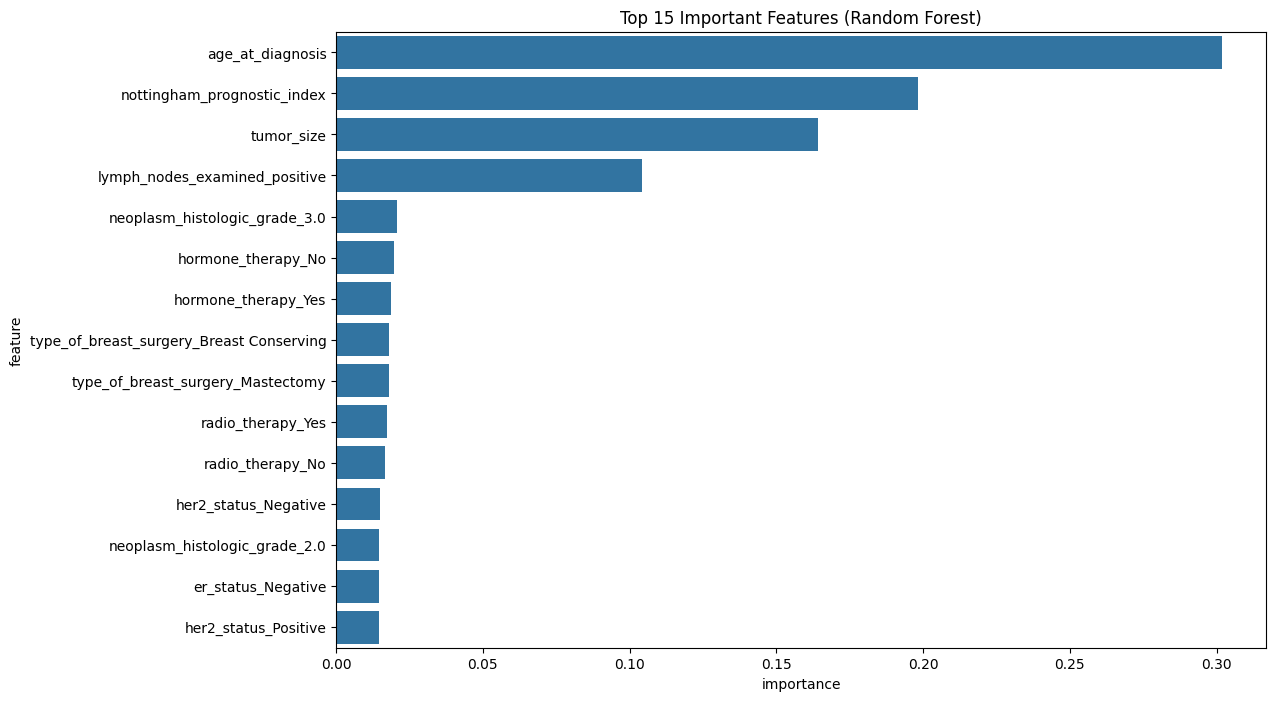

In [24]:
# ### 8. Feature Importance Analysis
# Example for Random Forest
rf = models['Random Forest']
feature_names = (preprocessor.named_transformers_['cat']
                 .get_feature_names_out(categorical_features)).tolist()
feature_names = numeric_features + feature_names

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importances.head(15))
plt.title('Top 15 Important Features (Random Forest)')
plt.show()


In [26]:
# Save the model and preprocessor
with open('breast_cancer_model.pkl', 'wb') as file:
    pickle.dump({'model': model, 'preprocessor': preprocessor}, file)

print("Model trained and saved to breast_cancer_model.pkl")

Model trained and saved to breast_cancer_model.pkl


In [33]:
# Accuracy Report
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.68
AUC-ROC: 0.74

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71       191
         1.0       0.64      0.64      0.64       152

    accuracy                           0.68       343
   macro avg       0.68      0.68      0.68       343
weighted avg       0.68      0.68      0.68       343

